In [28]:
segments = [
  "2bfcfe373379cd18/00000040--c8733fdf3b"
]
platform = "GENESIS_GV80_2025"

In [30]:
import copy
import numpy as np

from opendbc.car.common.conversions import Conversions as CV
from opendbc.can.parser import CANParser
from opendbc.car.hyundai.values import DBC

from openpilot.selfdrive.pandad import can_capnp_to_list
from openpilot.tools.lib.logreader import LogReader

for segment in segments:
  lr = LogReader(segment)

  messages = [
    ("MDPS", 100),
    ("ADAS_CMD_35_10ms", 100),
    ("WHEEL_SPEEDS", 100),
  ]

  cp = CANParser(DBC[platform]["pt"], messages, 1)

  mdps_history = []
  adas_cmd_35_10ms_history = []
  velocity_history = []
  timestamp_history = []

  last_vego_mph = 0
  timestamp = 0

  for msg in lr:
    if msg.which() == "can":
      cp.update(can_capnp_to_list([msg.as_builder().to_bytes()]))
      mdps_history.append(copy.copy(cp.vl["MDPS"]))
      adas_cmd_35_10ms_history.append(copy.copy(cp.vl["ADAS_CMD_35_10ms"]))
      timestamp_history.append(timestamp)
      timestamp += 0.01

      velocity_history.append(last_vego_mph)

    if msg.which() == "carState":
      last_vego_mph = msg.carState.vEgo * CV.MS_TO_MPH

In [31]:
def process(history, func):
  return np.array([func(h) for h in history])

ADAS_ActvACILvl2Sta = process(adas_cmd_35_10ms_history, lambda x: x["ADAS_ActvACILvl2Sta"])
ADAS_StrAnglReqVal = process(adas_cmd_35_10ms_history, lambda x: x["ADAS_StrAnglReqVal"])
ADAS_ACIAnglTqRedcGainVal = process(adas_cmd_35_10ms_history, lambda x: x["ADAS_ACIAnglTqRedcGainVal"])
STEERING_ANGLE_2 = process(mdps_history, lambda x: x["STEERING_ANGLE_2"])
STEERING_COL_TORQUE = process(mdps_history, lambda x: x["STEERING_COL_TORQUE"])
velocity_mph = np.array(velocity_history)
timestamps = np.array(timestamp_history)

In [32]:
import pandas as pd

df = pd.DataFrame({
  'timestamp': timestamps,
  'velocity_mph': velocity_mph,
  'ADAS_ActvACILvl2Sta': ADAS_ActvACILvl2Sta,
  'ADAS_StrAnglReqVal': ADAS_StrAnglReqVal,
  'ADAS_ACIAnglTqRedcGainVal': ADAS_ACIAnglTqRedcGainVal,
  'STEERING_ANGLE_2': STEERING_ANGLE_2,
  'STEERING_COL_TORQUE': STEERING_COL_TORQUE,
})

# Add derived columns
df['angle_error'] = df['ADAS_StrAnglReqVal'] - df['STEERING_ANGLE_2']
df['torque_reduction_pct'] = df['ADAS_ACIAnglTqRedcGainVal'] * 100
df['abs_col_torque'] = df['STEERING_COL_TORQUE'].abs()

# Filter for conditions:
# 1. ADAS_ActvACILvl2Sta == 2 (ADAS active)
# 2. velocity_mph > 10 (vehicle moving)
filtered_df = df[(df['ADAS_ActvACILvl2Sta'] == 2) & (df['velocity_mph'] > 10)].copy()

# Add additional analysis columns for the filtered data
if len(filtered_df) > 0:
  # Calculate rate of change for torque reduction gain
  filtered_df['tq_gain_delta'] = filtered_df['ADAS_ACIAnglTqRedcGainVal'].diff()

  # Identify potential override events (you may need to adjust threshold)
  # Assuming override when absolute column torque exceeds certain value
  torque_threshold = 50  # Adjust based on your data
  filtered_df['driver_override'] = filtered_df['abs_col_torque'] > torque_threshold

  # Mark transitions in override state
  filtered_df['override_transition'] = filtered_df['driver_override'].diff().fillna(0)

# Save to CSV
output_filename = f"adas_steering_analysis_{segment.replace('/', '_').replace('|', '_')}.csv"
filtered_df.to_csv(output_filename, index=False)

print(f"Data exported to: {output_filename}")
print(f"Total frames: {len(df)}")
print(f"Filtered frames (ADAS active & velocity > 10 mph): {len(filtered_df)}")
if len(filtered_df) > 0:
  print(f"Velocity range: {filtered_df['velocity_mph'].min():.1f} - {filtered_df['velocity_mph'].max():.1f} mph")
  print(f"Torque reduction gain range: {filtered_df['ADAS_ACIAnglTqRedcGainVal'].min():.3f} - {filtered_df['ADAS_ACIAnglTqRedcGainVal'].max():.3f}")
  print(f"Column torque range: {filtered_df['STEERING_COL_TORQUE'].min():.0f} - {filtered_df['STEERING_COL_TORQUE'].max():.0f}")

ModuleNotFoundError: No module named 'pandas'

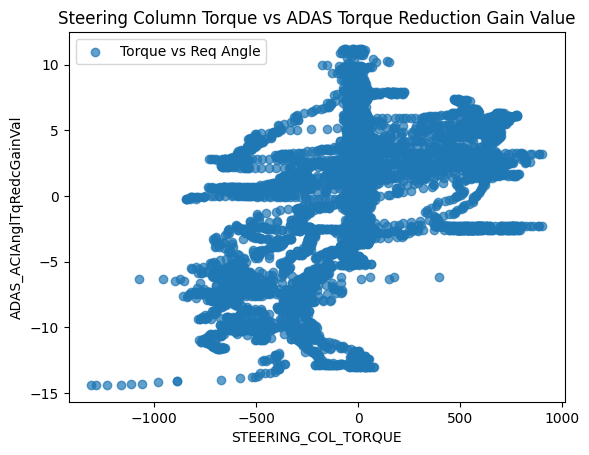

In [25]:
import matplotlib.pyplot as plt

valid_steering = (ADAS_ActvACILvl2Sta == 2) # only when cruise is activated and eyesight is braking

fig, ax = plt.subplots()

ax.set_title("Steering Column Torque vs ADAS Torque Reduction Gain Value")
ax.set_xlabel("STEERING_COL_TORQUE")
ax.set_ylabel("ADAS_ACIAnglTqRedcGainVal")

ax.scatter(
    STEERING_COL_TORQUE[valid_steering],
    ADAS_StrAnglReqVal[valid_steering],
    label="Torque vs Req Angle",
    alpha=0.7
)

ax.scatter(
    ADAS_ACIAnglTqRedcGainVal[valid_steering],
    STEERING_ANGLE_2[valid_steering],
    label="ADAS Gain vs Measured Angle",
    alpha=0.7
)

ax.legend()
plt.show()